## **Задание по реализации алгоритма k-means**
#### Выполнил: ***Амир Валеев 213 группа***

In [101]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## **1. Реализация k-means**

In [1548]:
class K_means:
    
    def train(self, X, k, mode = 'random', step_by_step = False):
        self.iter_count = 0
        self.X = X
        if mode == 'random':
            self.centroids = X[np.random.choice(len(X), k)]
        elif mode == 'km++':
            self.init_further(X, k)
        else: 
            raise ValueError('Wrong mode type!')
                             
        if step_by_step:
            self.history = {'centroids': [self.centroids], 'clusters': []}
        else:
            self.history = None
            
        self.complete = False
        
        while not self.complete:
            self.clusters_assignment = self.assign_clusters(X)
            new_centroids = self.change_centroids(X, k, self.clusters_assignment);
            self.complete = np.linalg.norm(new_centroids - self.centroids) < 1e-3       #обучаем пока отклонение новых центров не достигает 10^-3
            self.centroids = new_centroids
            if step_by_step:
                self.history['centroids'].append(self.centroids)
                self.history['clusters'].append(self.clusters_assignment)
                             
            self.iter_count += 1                   
            if self.iter_count > 1000:
                break
        
        
    def init_further(self, X, k):                                                          #Инициализация с выбором самого дальнего
        self.centroids = [X[np.random.randint(0, len(X) - 1)]]
        for i in range(1, k):
            dist = np.array([np.linalg.norm(self.centroids - x, axis=1).min() for x in X])
            index = np.argmax(dist)
            self.centroids.append(X[index])
    
    
    def assign_clusters(self, X):
        return np.array([np.argmin(np.linalg.norm(self.centroids - x, axis=1)) for x in X])
    
    
    def change_centroids(self, X, k, clusters_assignment):
        new_centroids = np.zeros_like(self.centroids)
                             
        for i in range(k):
            cluster = X[clusters_assignment == i]
            if not len(cluster):
                continue
            new_centroids[i] = np.mean(cluster, axis=0)
            
        return new_centroids
    
    
    def silhouette_ratio(self):
        ratio = []
        for k in range(len(self.centroids)):
            dist_inside = np.array(list(map(np.linalg.norm, self.X[self.clusters_assignment == k] - self.centroids[k])))
            average_inside = sum(dist_inside)/len(dist_inside)
            centroids_without = np.delete(self.centroids, k, axis=0)
            closest_cluster = np.argmin(np.linalg.norm(centroids_without - self.centroids[k], axis=1))
            average_to_nearest = np.linalg.norm(centroids_without[closest_cluster] - self.centroids[k])
            ratio.append((-average_inside + average_to_nearest) / max(average_inside, average_to_nearest))
        return (np.std(ratio), np.mean(ratio))
    
    
    def group_by_clusters(self):
        clusters_sorted = list(range(len(self.centroids)))
        clusters_sorted.sort(key = lambda x: len(self.X[self.clusters_assignment == x]))
        new_set = sort_obj_in_cluster(self.X[self.clusters_assignment == clusters_sorted[0]], self.centroids[clusters_sorted[0]])  
        for k in range(1, len(self.centroids)):
            new_set = np.array(np.append(new_set, sort_obj_in_cluster(self.X[self.clusters_assignment == clusters_sorted[k]], self.centroids[clusters_sorted[k]]), axis = 0))
        return new_set
        
    
    def __str__(self):
        if self.complete:                                                            
            print('Finished after {} iterations'.format(self.iter_count))                 
            if self.history:                                                             # Можно вывести пошаговую информацию о том как сработал алгоритм
                             
                fig, axs = plt.subplots(self.iter_count - 1)
                fig.set_figheight(6 * (self.iter_count - 1))
                fig.set_figwidth(6)
                             
                for i in range(self.iter_count-1):
                    axs[i].scatter(self.X[:, 0], self.X[:, 1], c=self.history['clusters'][i-1])
                    for k in range((len(self.centroids))):
                        axs[i].scatter([self.history['centroids'][i][k][0]], [self.history['centroids'][i][k][1]], s=400, marker='*')
            
            else:
            
                fig, axs = plt.subplots()
                axs.scatter(self.X[:, 0], self.X[:, 1], c=self.clusters_assignment)
                for k in range((len(self.centroids))):
                    axs.scatter([self.centroids[k][0]], [self.centroids[k][1]], s=400, marker = "*")
               # axs.scatter(km_1.centroids[1][0],km_1.centroids[1][1], color = "blue", s = 200)
        
        else:
            print('Still uncomplete!')
        return ""

## **2. Зависимость от начальной инициализации**

### Посмотрим за сколько итераций в среднем производится кластеризация в двух вариантах инициализации 
- Произвольная инициализация ( стоит изначально )
- Метод взятия дальнего соседа ( в параметре *mode* указать ***further*** )

In [278]:
sets = [np.random.uniform(-100, 100, size=(200,2)) for x in range(100)]

### Генирируем 100 произвольных датасетов

In [279]:
km = K_means()
iter_rand = []
iter_further = []
for i in range(100):
    km.train(sets[i], 4)
    iter_rand.append(km.iter_count)
    km.train(sets[i], 4, mode = 'km++')
    iter_further.append(km.iter_count)

### Построим график количеста итераций в зависимости от метода
#### ***blue*** - рандом, ***red*** - метод K-means++
#### Видим, что K-means++ сходится быстрее

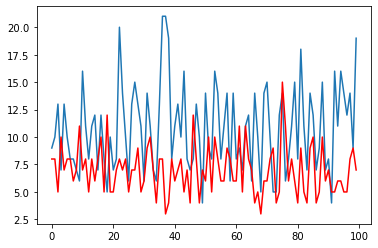

In [280]:
fig, axs = plt.subplots()

axs.plot(range(100), iter_rand)
axs.plot(range(100), iter_further, color = "red")

#### Среднее число итераций при рандомном выборе

In [281]:
sum(iter_rand)/100

10.76

#### Среднее число итераций в методе k-means++

In [282]:
sum(iter_further)/100

7.02

### В среднем сходится быстрее

## **3. В каких задачах применим K-means**

## Рассмотрим сеты на которых метод k-means работает ***хорошо***


#### Из алгоритма подбора очередного центроида и использования **2-ой Гёльдеровской нормы** понятно, что метод пытается разделить все данные **на сферы**, поэтому логичнее работает на данных состоящий из таких сфер

In [1701]:
def make_gauss_classes(k, scale = 0):
    if not scale:
        scale = np.random.uniform(5, 15)
    dataset = np.random.normal(loc = np.random.uniform(-100,100, size=(1,2)), scale = scale, size = (np.random.randint(10, 100),2))
    for i in range(k-1):
        dataset = np.append(dataset, np.random.normal(loc = np.random.uniform(-100,100, size=(1,2)), scale = scale, size = (np.random.randint(10,100),2)), axis = 0)
    np.random.shuffle(dataset)
    return dataset

### Реализуем функцию для создания гауссовых распределений на плоскости

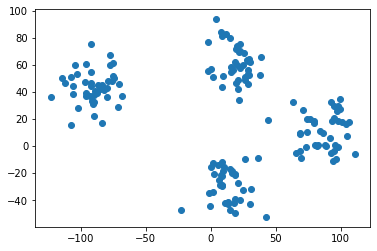

In [867]:
set_1 = make_gauss_classes(4)

fig, axs = plt.subplots()
axs.scatter(set_1[:, 0], set_1[:, 1])

Finished after 4 iterations



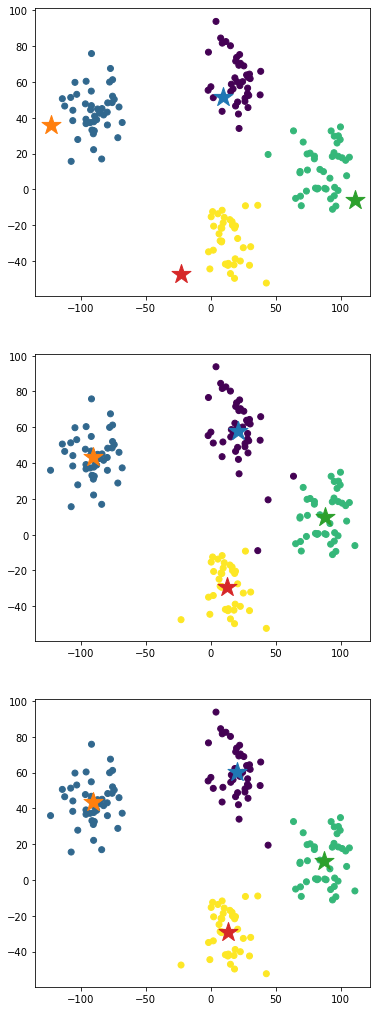

In [870]:
km_1 = K_means()
km_1.train(set_1, 4, mode = "km++", step_by_step = True)
print(km_1)

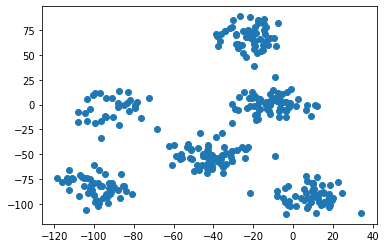

In [304]:
set_2 = make_gauss_classes(6, scale = 10)

fig, axs = plt.subplots()
axs.scatter(set_2[:, 0], set_2[:, 1])

Finished after 3 iterations



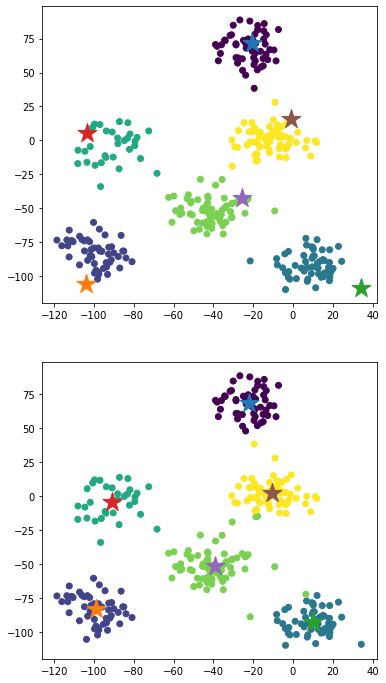

In [839]:
km_2 = K_means()
km_2.train(set_2, 6, mode = "km++", step_by_step = True)
print(km_2)

### Видим что, метод быстро сходится и логично кластеры

## Понятно, что на других типах данных такой алгоритм ***лучше не применять***, он теряет смысл на

In [311]:
bad_set_1 = np.random.uniform(-100, 100, size=(200,2))

### Любом более-менее равномерном распределении

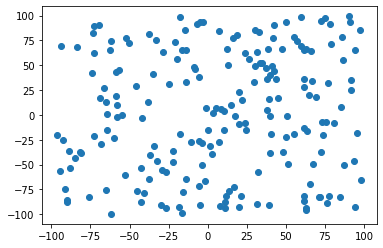

In [312]:
fig, axs = plt.subplots()
axs.scatter(bad_set_1[:, 0], bad_set_1[:, 1])

Finished after 7 iterations



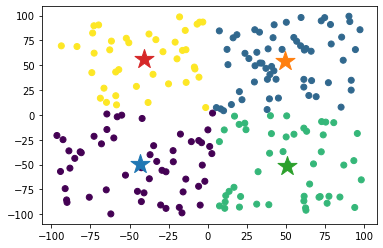

In [841]:
bad_km_1 = K_means()
bad_km_1.train(bad_set_1, 4, mode = "km++")
print(bad_km_1)

### Любых данных без четко выраженной структуры

#### Возьмем то же Нормальное распределение, но растянем каждую каплю вдоль осей на произвольный скаляр ***a*** из интервала (1, 40)

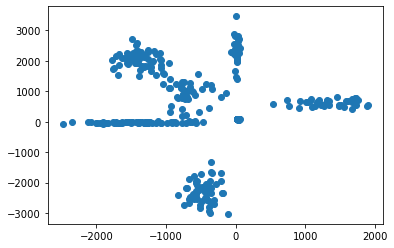

In [739]:
bad_set_2 = np.random.normal(loc = np.random.uniform(-100,100, size=(1,2)), scale = scale, size = (np.random.randint(30, 70),2))
for i in range(6):
    bad_set_2 = np.append(bad_set_2, np.random.normal(loc = np.random.uniform(-100,100, size=(1,2)), scale = scale, size = (np.random.randint(30,70),2))
                          * [np.random.uniform(1,40),np.random.uniform(1,40)], axis = 0)

fig, axs = plt.subplots()
axs.scatter(bad_set_2[:, 0], bad_set_2[:, 1])

Finished after 6 iterations



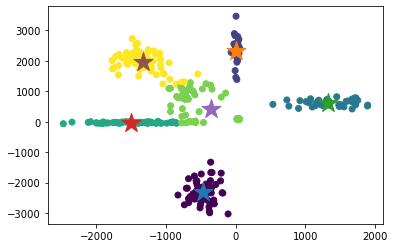

In [845]:
bad_km_2 = K_means()
bad_km_2.train(bad_set_2, 6, mode = "km++")
print(bad_km_2)

### K-means чувствителен к **нормировке** данных (если не нормированы, начинает разделять по полосам)

#### Например, растянем нормальное распределение по первой координате X

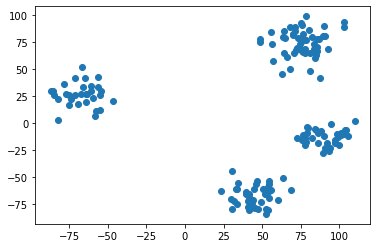

In [858]:
set_not_normed = make_gauss_classes(4)

fig, axs = plt.subplots()
axs.scatter(set_not_normed[:, 0], set_not_normed[:, 1])

Finished after 3 iterations



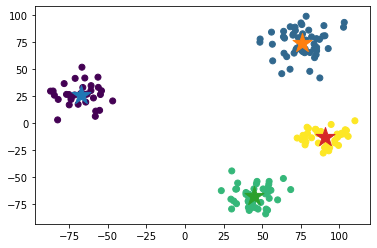

In [859]:
km_norm = K_means()
km_norm.train(set_not_normed, 4, mode = "km++")
print(km_norm)

### Растягиваем

In [861]:
set_not_normed = set_not_normed * [10000, 1]

Finished after 4 iterations



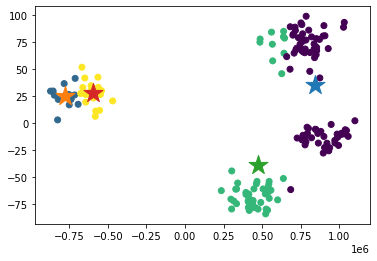

In [862]:
km_norm = K_means()
km_norm.train(set_not_normed, 4, mode = "km++")
print(km_norm)

### Также K-means **чувствителен к выбросам**

#### Добавим произвольный выброс, тогда один из классов будет всегда занят им и состоять лишь из него одного

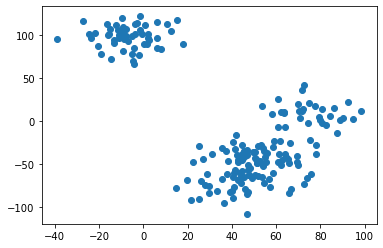

In [863]:
set_blowout = make_gauss_classes(4)

fig, axs = plt.subplots()
axs.scatter(set_blowout[:, 0], set_blowout[:, 1])

In [864]:
set_blowout = np.append(set_blowout, [[1e3, 1e3]], axis = 0)

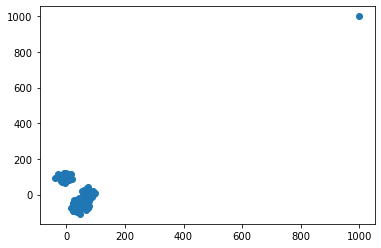

In [865]:
fig, axs = plt.subplots()
axs.scatter(set_blowout[:, 0], set_blowout[:, 1])

Finished after 8 iterations



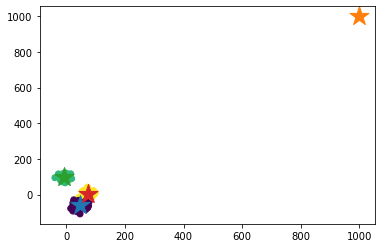

In [866]:
km_blowout = K_means()
km_blowout.train(set_blowout, 4, mode = "km++")
print(km_blowout)

## **4. Подбор числа кластеров**

### Будем использовать **коэффициент силуета**, который вычисляется по такой формуле

$$ \delta = \frac{b - a}{max(a,b)}$$

#### где ***b*** - среднее расстояние объекта до всех объектов из ближайшего кластера, ***a*** - среднее внутрикластверное расстояние данного объекта

### ***Таким образом нам небходимо, чтобы среднеквадратичное отклонение коэффициента силуета было как можно меньше и чтобы он был как можно ближе к 1***

In [834]:
def define_cluster_amount(km, X):
    sigma = 1
    average = -1
    k = 0
    for i in range(2, len(X) // 5):
        km.train(X, i, "km++")
        new = km.silhouette_ratio()
        if new[0] < sigma:
            if new[1] > average:
                sigma, average = new
                k = i
    km.train(X, k, "km++")
    return (sigma, average, k)

#### Функция возвращает кортеж из среднеквадратичного отклонения, среднего коэфф. силуета и приемлимого числа кластеров 

### Проверим на примерах

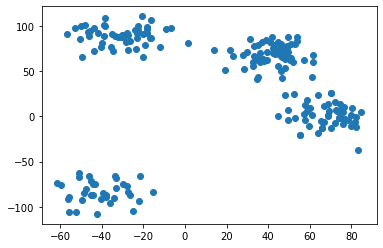

In [878]:
set_test_1 = make_gauss_classes(4)

fig, axs = plt.subplots()
axs.scatter(set_test_1[:, 0], set_test_1[:, 1])

In [879]:
km_t1 = K_means()

define_cluster_amount(km_t1, set_test_1)

(0.035878260589242865, 0.8289991492911027, 4)

### Видим, что функция верно определила число кластеров, среднеквадратичное отклонение достаточно мало и коэффициент силуета тоже в пределах допустимого 

Finished after 2 iterations



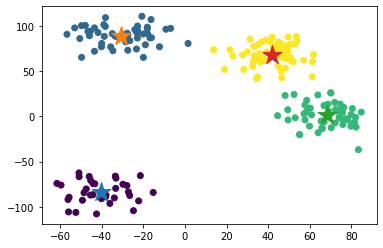

In [880]:
print(km_t1)

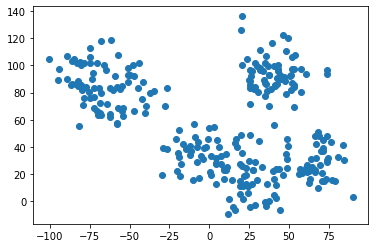

In [882]:
set_test_2 = make_gauss_classes(6)

fig, axs = plt.subplots()
axs.scatter(set_test_2[:, 0], set_test_2[:, 1])

In [885]:
km_t2 = K_means()

define_cluster_amount(km_t2, set_test_2)

(0.06962741562636993, 0.7176116085032338, 4)

### Видим, что хотя изначально мы и запросили гауссово распределение с **6 кластерами**, оно получилось такое, что больше похоже, что в нём лишь **4 кластера**. И алгоритм правильно это определил

Finished after 4 iterations



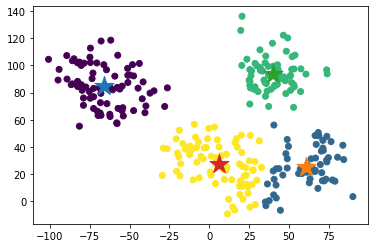

In [887]:
print(km_t2)

### Попробуем датасет с нормальным распределением

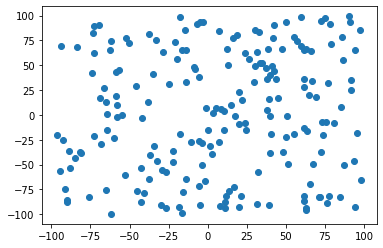

In [888]:
fig, axs = plt.subplots()
axs.scatter(bad_set_1[:, 0], bad_set_1[:, 1])

In [891]:
define_cluster_amount(bad_km_1, bad_set_1)

(0.016256614173205397, 0.4766107886188163, 2)

In [892]:
define_cluster_amount(bad_km_1, bad_set_1)

(0.00990215221509538, 0.5648462002443524, 3)

In [895]:
define_cluster_amount(bad_km_1, bad_set_1)

(0.008222181947372481, 0.5876539235215643, 4)

#### ***В данном случае получаем всегда разный результат и низкий средний коэффициент силуета***

#### Таким образом можно **програмно** определять поддаются данные классификации с помощью K-means или нет, проблема лишь в том, что работает долго




## **5. Зависимость времени работы алгоритма определения числа кластеров от объема данных**

In [904]:
from time import time

def make_gauss_classes_2(k, amount, scale = 0):
    if not scale:
        scale = np.random.uniform(10, 15)
    dataset = np.random.normal(loc = np.random.uniform(-100,100, size=(1,2)), scale = scale, size = (amount,2))
    for i in range(k-1):
        dataset = np.append(dataset, np.random.normal(loc = np.random.uniform(-100,100, size=(1,2)), scale = scale, size = (amount,2)), axis = 0)
    return dataset

In [923]:
sets = [make_gauss_classes_2(4, x) for x in range(5, 100)]

### Создадим 95 сетов с Гауссовым распределением и линейно увеличивающимся числом объектов

In [1582]:
time_exec = []
km_time = K_means()
for i in range(0, 95):
    start_time = time()
    define_cluster_amount(km_time, sets[i])
    time_exec.append(time() - start_time)

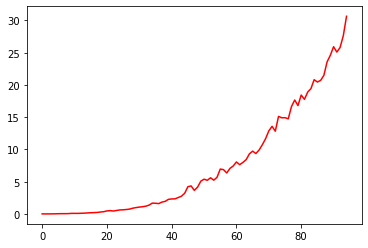

In [1584]:
fig, axs = plt.subplots()

axs.plot(range(95), time_exec, color = "red")

### Тогда график зависимости времени выполнения от числа элементов выглядит так, видим что сложность растет **экспоненциально** при увеличении объектов

## **6. Матрица попарных расстояний и её визуализация**

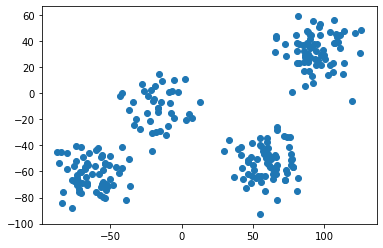

In [1708]:
set_new = make_gauss_classes(4)

fig, axs = plt.subplots()
axs.scatter(set_new[:, 0], set_new[:, 1])

In [1709]:
D = (set_new[:,0][:, np.newaxis] - set_new[:,0]) ** 2
D += (set_new[:,1][:, np.newaxis] - set_new[:,1]) ** 2
D = np.sqrt(D)

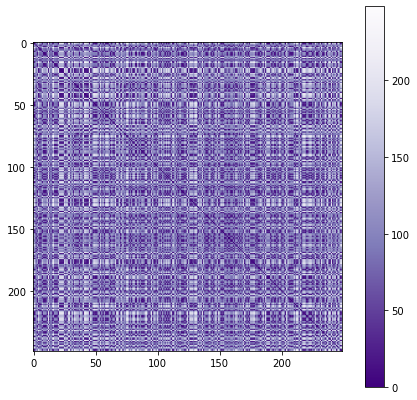

In [1710]:
plt.figure(figsize=(7, 7))
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

#### В неотсортированном виде выглядит так

### Сгруппируем объекты по класетрам и будем упорядочивать кластеры по **возрастанию числа элементов** в нём - метод  **group_by_clasters()**

In [1714]:
km_new = K_means()
km_new.train(set_new, 4, mode = "km++")

set_new2 = km_new.group_by_clusters()

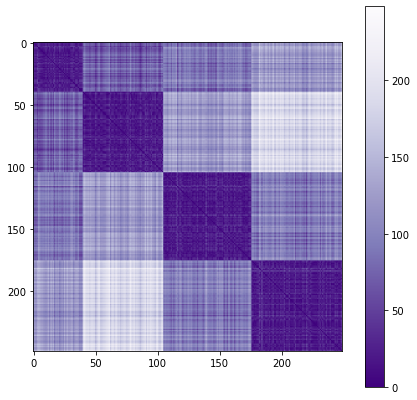

In [1715]:
D = (set_new2[:,0][:, np.newaxis] - set_new2[:,0]) ** 2
D += (set_new2[:,1][:, np.newaxis] - set_new2[:,1]) ** 2
D = np.sqrt(D)

plt.figure(figsize=(7, 7))
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

### Получаем на диагонали увеличиващиеся квадраты

### И еще мы можем избавится от **сеточки внутри центральных квадратов**, упорядочив элементы **внутри кластеров**, так, чтобы сначала шли элементы находящиеся ближе всего к элементам своего кластера

In [1756]:
def sort_obj_in_cluster(X, centroid):
    return X[np.linalg.norm(X-centroid, axis = 1).argsort()]

In [1717]:
set_new2 = km_new.group_by_clusters()

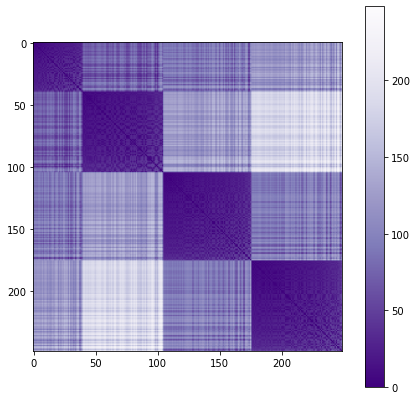

In [1718]:
D = (set_new2[:,0][:, np.newaxis] - set_new2[:,0]) ** 2
D += (set_new2[:,1][:, np.newaxis] - set_new2[:,1]) ** 2
D = np.sqrt(D)

plt.figure(figsize=(7, 7))
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

### В итоге получили более приятный **градиент** внутри квадратов

## **Примеры**

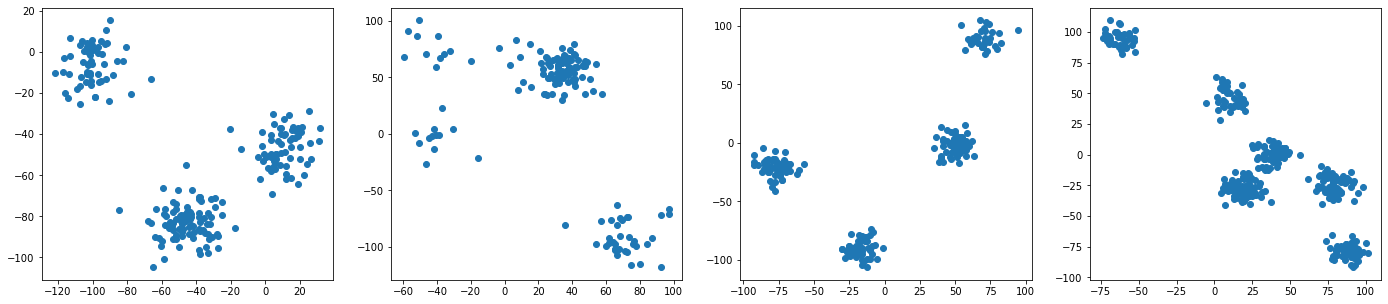

In [1744]:
sets_new = [make_gauss_classes(x) for x in range(3,7)]

fig, axs = plt.subplots(1,4)
fig.set_figheight(5)
fig.set_figwidth(6 * 4)

for i in range(4):
    axs[i].scatter(sets_new[i][:, 0], sets_new[i][:, 1])

### Создали 4 датасета с числом кластеров от 3 до 6

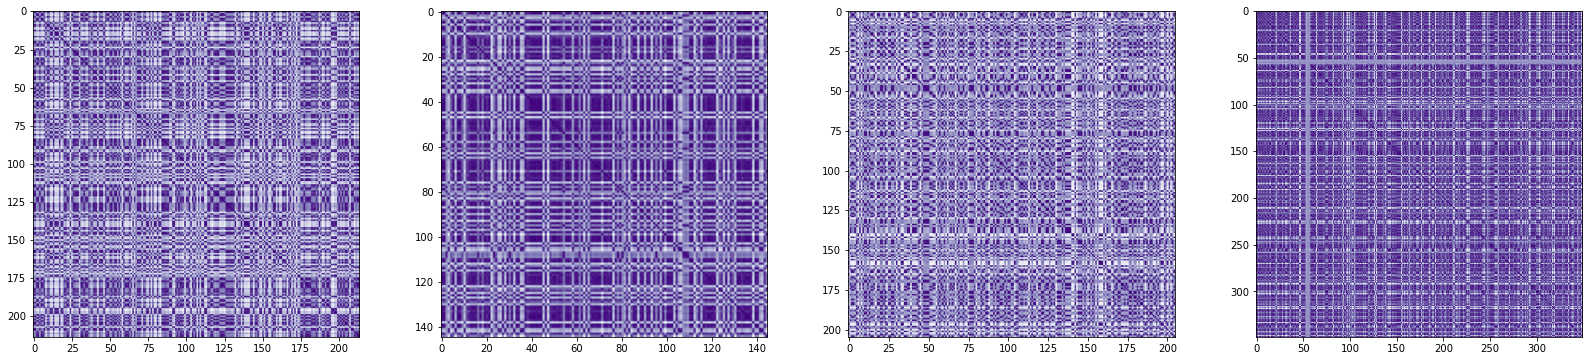

In [1753]:
fig, axs = plt.subplots(1,4)
fig.set_figheight(6)
fig.set_figwidth(7 * 4)

for i in range(len(sets_new)):
    D = (sets_new[i][:,0][:, np.newaxis] - sets_new[i][:,0]) ** 2
    D += (sets_new[i][:,1][:, np.newaxis] - sets_new[i][:,1]) ** 2
    D = np.sqrt(D)
    axs[i].imshow(D, cmap='Purples_r')
    

### Без какого-либо упорядочивания

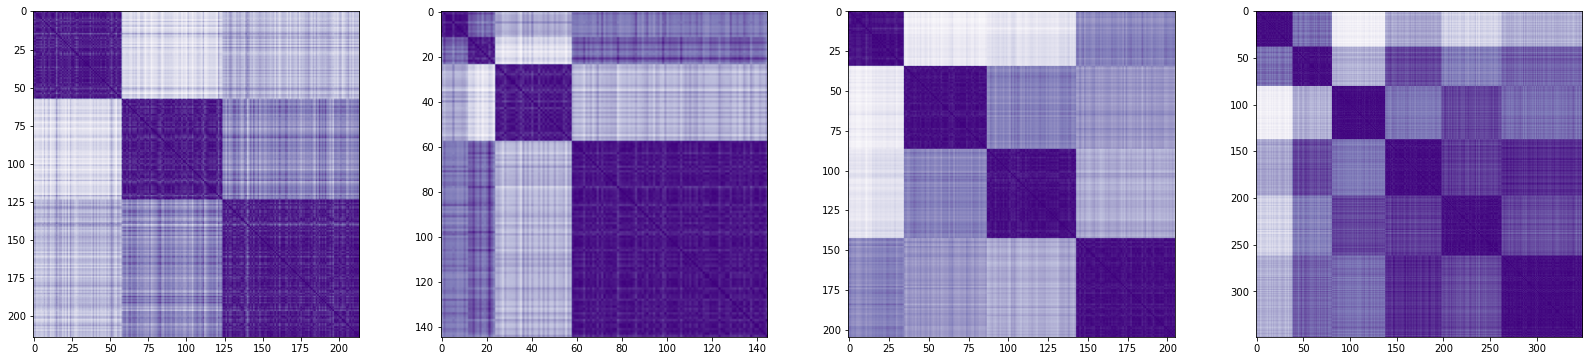

In [1752]:
fig, axs = plt.subplots(1,4)
fig.set_figheight(6)
fig.set_figwidth(7 * 4)

km = K_means()

for i in range(3,7):
    km.train(sets_new[i-3], i, mode = "km++")
    set_new = km.group_by_clusters()
    D = (set_new[:,0][:, np.newaxis] - set_new[:,0]) ** 2
    D += (set_new[:,1][:, np.newaxis] - set_new[:,1]) ** 2
    D = np.sqrt(D)
    axs[i-3].imshow(D, cmap='Purples_r')

### Без упорядочивания внутри кластеров

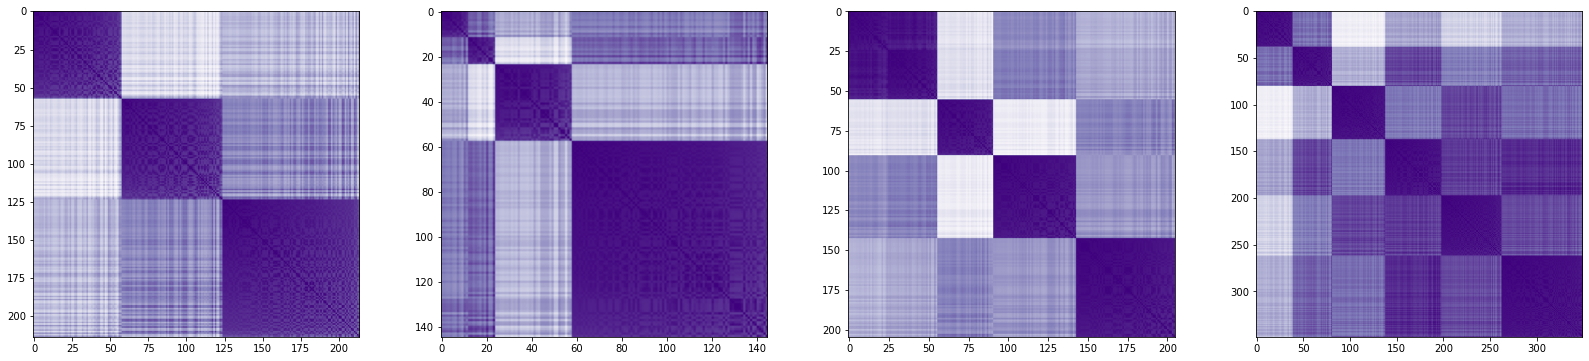

In [1757]:
fig, axs = plt.subplots(1,4)
fig.set_figheight(6)
fig.set_figwidth(7 * 4)

km = K_means()

for i in range(3,7):
    km.train(sets_new[i-3], i, mode = "km++")
    set_new = km.group_by_clusters()
    D = (set_new[:,0][:, np.newaxis] - set_new[:,0]) ** 2
    D += (set_new[:,1][:, np.newaxis] - set_new[:,1]) ** 2
    D = np.sqrt(D)
    axs[i-3].imshow(D, cmap='Purples_r')

### Финальный вариант